In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [3]:
adata = scv.datasets.pancreas()

In [4]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/home/icb/leonardo.golinelli/miniconda3/envs/gpvelo/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:25) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
u = adata.layers['Mu']
s = adata.layers['Ms']

In [7]:
dic = {}
velocity = np.empty((3696,2000))
gamma_list = []
for i in range(2000):
  # Assume `data` is a 2-dimensional numpy array of shape (n, 2).
  x = u[:, i]
  y = s[:, i]

  # Compute the centroid.
  centroid_x = np.mean(x)
  centroid_y = np.mean(y)

  # Compute the Euclidean distance from each point to the centroid.
  distances = np.sqrt((x - centroid_x)**2 + (y - centroid_y)**2)
  
  # Compute the 1st and 99th percentiles of the distances.
  q1 = np.percentile(distances, 1)
  q99 = np.percentile(distances, 99)

  # Now, you can select the data at these extreme quantiles.
  q1_u = x[distances <= q1]
  q99_u = x[distances >= q99]
  q1_s = y[distances <= q1]
  q99_s = y[distances >= q99]

  #concatenate extreme percentiles for the linear fitting
  extr_q_u = np.concatenate((q1_u, q99_u))
  extr_q_s = np.concatenate((q1_s, q99_s))

  #fit u = gamma * s
  model = LinearRegression(fit_intercept=False)
  model.fit(extr_q_s.reshape(-1, 1), extr_q_u)  # need to reshape s to be a 2D array

  gamma = model.coef_[0]
  gamma_list.append(gamma)

  v = x - gamma * y
  velocity[:,i] = v


In [8]:
velocity.shape

(3696, 2000)

In [11]:
adata.layers['velocity'] = velocity

In [12]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/96 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


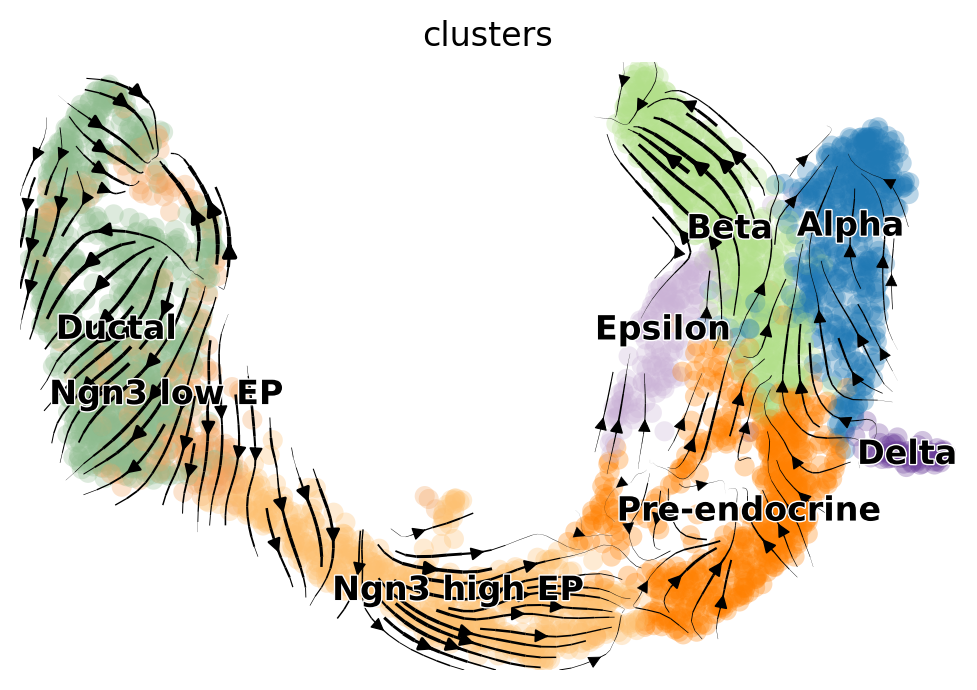

In [13]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

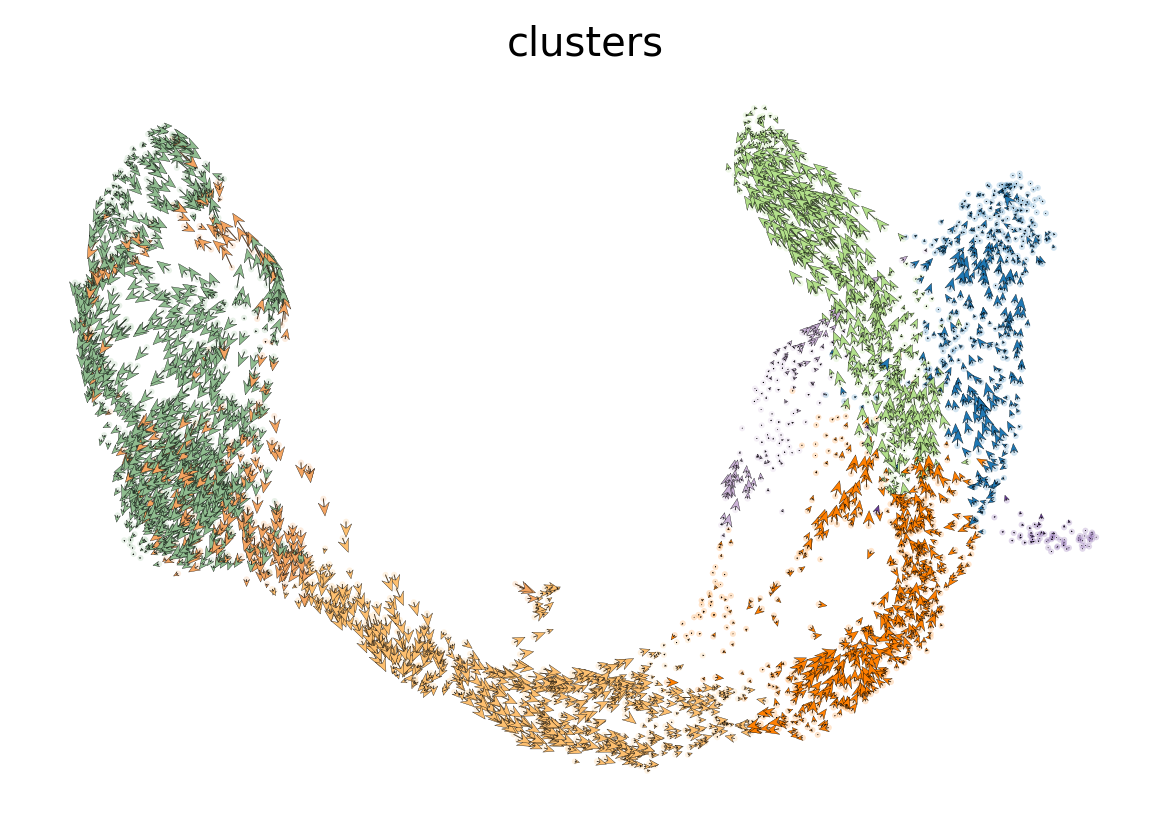

In [14]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

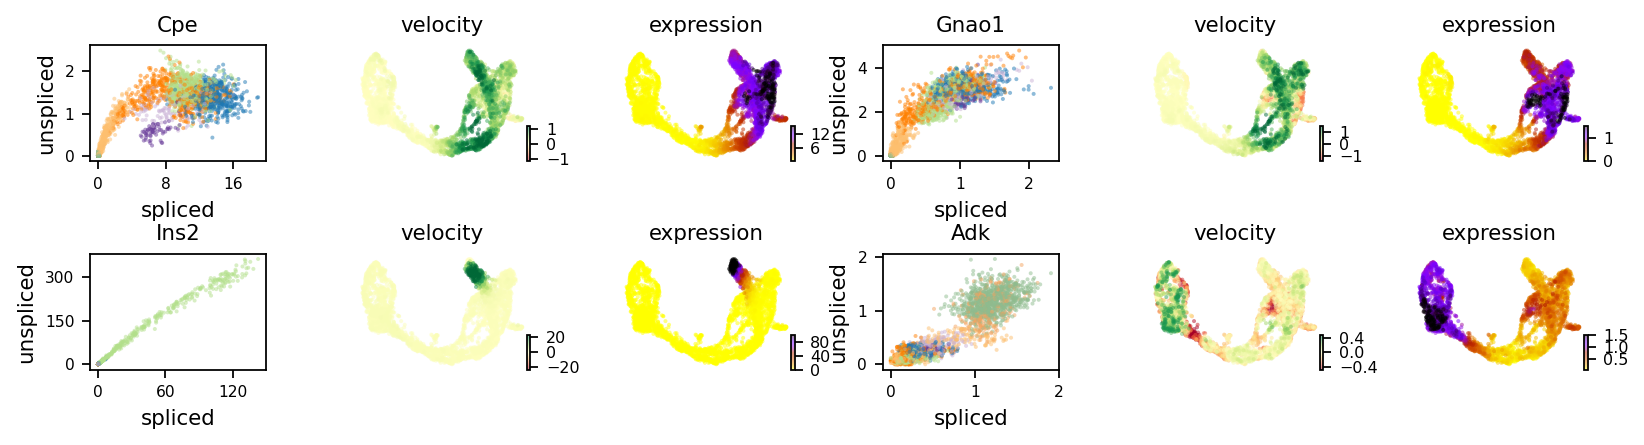

In [15]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [16]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'
    obsp: 'distances', 'connectivities'